### Contrastive explanation on MNIST (Tensorflow)

This is an example of `ContrastiveExplainer` on MNIST with a Tensorflow model. `ContrastiveExplainer` is an optimization based method for generating explanations (pertinent negatives and pertinent positives), supporting classification tasks only. If using this explainer, please cite the original work: https://arxiv.org/abs/1802.07623.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from omnixai.data.image import Image
from omnixai.explainers.vision import ContrastiveExplainer

The following code loads the training and test datasets. We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. In this example, `Image` is constructed from a numpy array containing a batch of digit images.

In [3]:
# Load the MNIST dataset
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Use `Image` objects to represent the training and test datasets
train_imgs, train_labels = Image(x_train.astype('float32'), batched=True), y_train
test_imgs, test_labels = Image(x_test.astype('float32'), batched=True), y_test

The preprocessing function takes an `Image` instance as its input and outputs the processed features that the ML model consumes. In this example, the pixel values are normalized to [0, 1].

In [4]:
preprocess_func = lambda x: np.expand_dims(x.to_numpy() / 255, axis=-1)

We train a simple convolutional neural network for this task. The network has two convolutional layers and one dense hidden layer. 

In [5]:
batch_size = 128
num_classes = 10
epochs = 10

# Preprocess the training and test data
x_train = preprocess_func(train_imgs)
x_test = preprocess_func(test_imgs)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Model structure
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(
    32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(num_classes))

# Train the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test)
)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1712 - accuracy: 0.9493 - val_loss: 0.0509 - val_accuracy: 0.9837
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0467 - accuracy: 0.9857 - val_loss: 0.0364 - val_accuracy: 0.9880
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0331 - accuracy: 0.9896 - val_loss: 0.0323 - val_accuracy: 0.9884
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0345 - val_accuracy: 0.9890
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0171 - accuracy: 0.9942 - val_loss: 0.0371 - val_accuracy: 0.9880
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 0.0297 - val_accuracy: 0.9906
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 0.0428 - val_accuracy: 0.9887
Epoch 

To initialize `ContrastiveExplainer`, we need to set the following parameters:
  
  - `model`: The ML model to explain, e.g., `torch.nn.Module` or `tf.keras.Model`.
  - `preprocess_function`: The preprocessing function that converts the raw data (a `Image` instance) into the inputs of `model`.
  - "optimization parameters": e.g., `binary_search_steps`, `num_iterations`. Please refer to the docs for more details.

In [6]:
explainer = ContrastiveExplainer(
    model=model,
    preprocess_function=preprocess_func
)

We can simply call `explainer.explain` to generate explanations for this classification task. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `test_imgs[0:5]`.

Binary step: 5 |----------------------------------------| 0.6%  

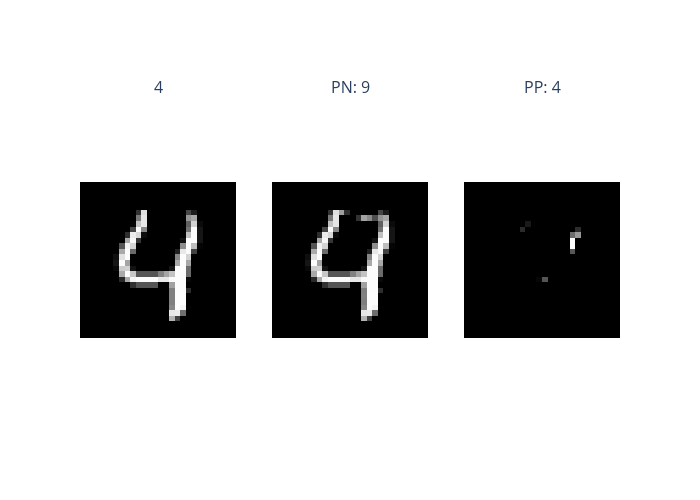

In [7]:
explanations = explainer.explain(test_imgs[0:5])
explanations.ipython_plot(index=4)